Lecture 1 (practice)
======================


## About

During this part of the assignment, you will gain experience working with different datasets. These datasets are diverse and should provide you with examples of how to work with various sources of data.

* **CIFAR-10**: This is a 'classic' dataset for Computer Vision. The CIFAR-10 dataset consists of 60,000 32x32 color images across 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

* **DTD**: The DTD is a texture database consisting of 5,640 images, organized according to a list of 47 terms (categories) inspired by human perception. There are 120 images for each category. Image sizes range between 300x300 and 640x640, and the images contain at least 90% of the surface area representing the category attribute.

* **COCO-O**: COCO-O (Out-of-distribution) contains six domains (sketch, cartoon, painting, weather, handmade, tattoo) of COCO objects, which are challenging to detect for most existing detectors. The dataset includes a total of 6,782 images. It is primarily a dataset for object detection, but during this assignment, we will treat it as a classification dataset.

For CIFAR-10, we will use the native PyTorch dataset structure; for DTD, the Hugging Face dataset library will be used, and for COCO-O, the process will be done manually.

<hr> 

* The <b><font color="red">red</font></b> color indicates the task that should be done, like <b><font color="red">[TODO]</font></b>: ...
* Addicitional comments, hints are in <b><font color="blue">blue</font></b>. For example <b><font color="blue">[HINT]</font></b>: ...

## Prelimiaries

In [ ]:
!pip install datasets
!pip install fiftyone

In [2]:
import os
import gdown
import zipfile

import random
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from datasets import load_dataset # HuggingFace dedicated lib

import fiftyone as fo

## Auxilary functions

In [5]:
def plot_images_with_labels(images: list[Image.Image], labels: list[str], num_cols: int = 3, fig_size: float = 2) -> None:
    """Plot a grid of images with their corresponding labels."""
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_size * num_rows, fig_size * num_rows))
    axes = axes.flatten() 
    
    for i, (img, label) in enumerate(zip(images, labels)):
        if isinstance(img, Image.Image):
            axes[i].imshow(img)
        else:
            axes[i].imshow(img, cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')  # Turn off axis

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Load data

In [3]:
# Set the local folder with the data
path_data = "./data"
os.makedirs(path_data, exist_ok=True)

### CIFAR10

In [96]:
# Load the data using torchvision 'datasets'
cifar10_dataset_train = datasets.CIFAR10(root=path_data, train=True, download=True, transform=None)
cifar10_dataset_test = datasets.CIFAR10(root=path_data, train=False, download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [97]:
# Let's have a look what we have loaded
print(cifar10_dataset_train)
print(cifar10_dataset_test)
print()
print(type(cifar10_dataset_train))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

<class 'torchvision.datasets.cifar.CIFAR10'>


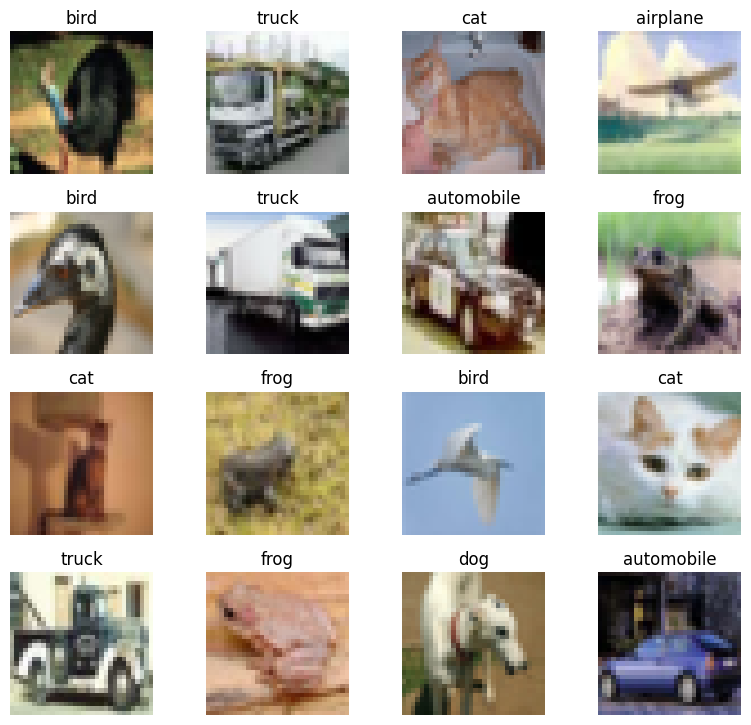

In [147]:
# Fast look at some random images
n = 16

random_indexes = random.sample(range(len(cifar10_dataset_train)), n)
random_elements = [cifar10_dataset_train[indx] for indx in random_indexes]

images, targets = zip(*random_elements)
labels = [cifar10_dataset_train.classes[target] for target in targets]
plot_images_with_labels(images, labels, num_cols=4)

### DTD dataset

In [132]:
# Let's load using HuggingFace 
dtd_dataset = load_dataset("tanganke/dtd", cache_dir=path_data)

In [133]:
# Let's have a look what we have loaded
dtd_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3760
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1880
    })
})

In [134]:
# Single element
dtd_dataset['train'][0]['label']

0

In [145]:
# Labels names
labels_info = dtd_dataset['train'].features['label'].names

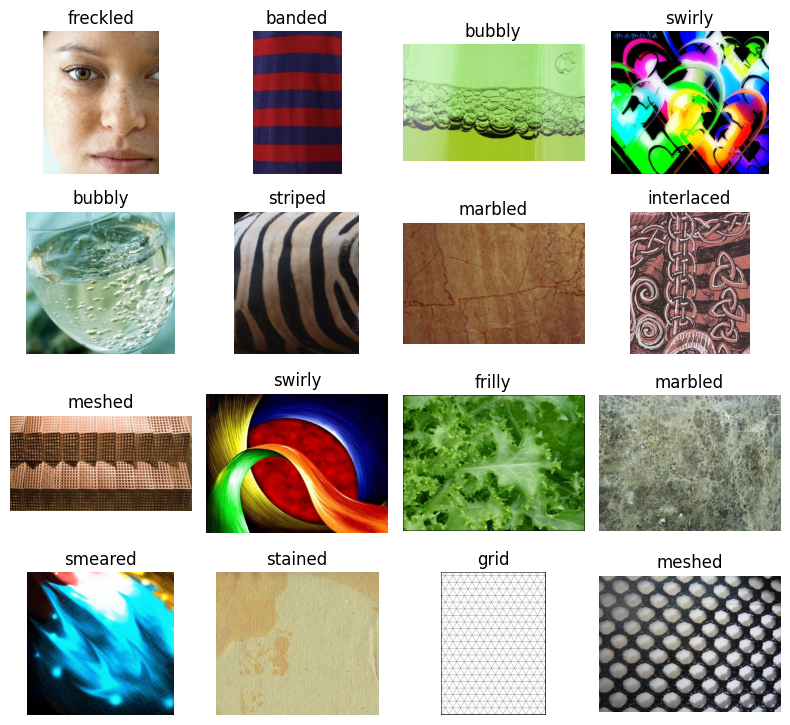

In [146]:
# Fast look at some random images
n = 16

random_indexes = random.sample(range(len(dtd_dataset['train'])), n)
random_elements_ = [dtd_dataset['train'][indx] for indx in random_indexes]

random_elements = [(elem['image'], labels_info[elem['label']]) for elem in random_elements_]
images, labels = zip(*random_elements)
plot_images_with_labels(images, labels, num_cols=4)

### COCO-O

In [ ]:
# Download the file following https://github.com/alibaba/easyrobust/tree/main/benchmarks/coco_o
url = 'https://drive.google.com/uc?id=1aBfIJN0zo_i80Hv4p7Ch7M8pRzO37qbq'
zip_file_path = os.path.join(path_data, 'ood_coco.zip')
gdown.download(url, zip_file_path, quiet=False)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(path_data)

<b><font color="red">[TODO]</font></b>: Based on the path of the loaded dataset, display random 16 samples with labels, similar to the CIFAR10 and DTD above.

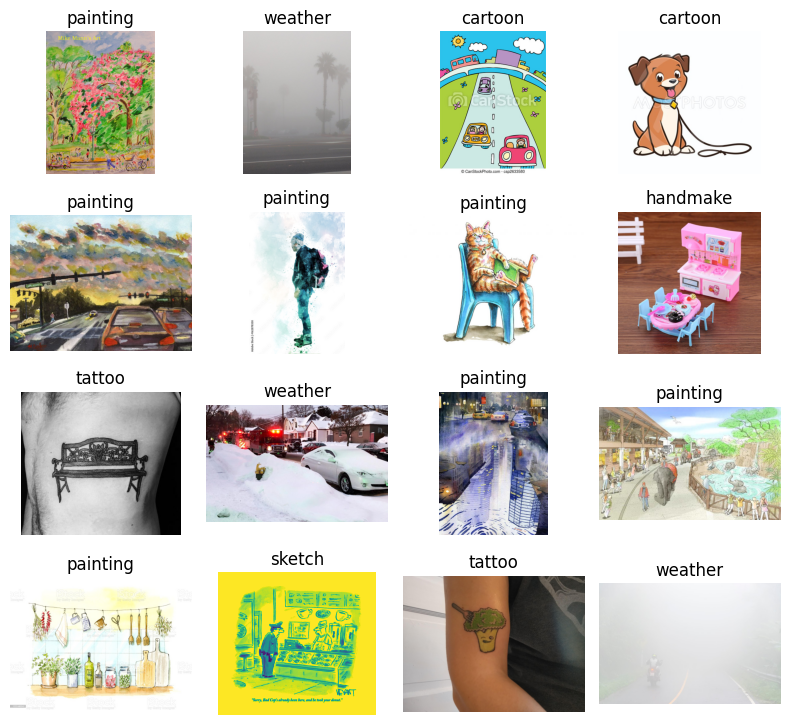

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 753M/1.20G [00:40<00:16, 27.4MB/s]

In [5]:
# Fast look at some random images
n = 16

# YOUR CODE HERE

## Dataset analysis with fiftyone lib

For more advanced dataset analysis, we will use the [FiftyOne](https://voxel51.com/) library. We will start with the basic functionality of viewing images and ground truth labels. Subsequently, we will also add predictions and extend the analysis to the Object Detection problem in the next assignment. As an example, we will use the COCO-O dataset, and you are encouraged to try applying this to other datasets as well.

In [6]:
# Load all elements
path_coco_o = os.path.join(path_data, 'ood_coco')
all_elements_coco = []
for label in os.listdir(path_coco_o):
    path_label_dir = os.path.join(path_coco_o, label, 'val2017')
    all_elements_coco += [(os.path.join(path_label_dir, img), label) for img in os.listdir(path_label_dir)]

In [7]:
print(len(all_elements_coco))

6782


In [8]:
all_elements_coco[:3]

[('./data/ood_coco/tattoo/val2017/000000000808.jpeg', 'tattoo'),
 ('./data/ood_coco/tattoo/val2017/000000000737.jpeg', 'tattoo'),
 ('./data/ood_coco/tattoo/val2017/000000000367.jpeg', 'tattoo')]

In [9]:
# Load the data into FiftyOne samples
samples = []
for image_path, label in all_elements_coco:
    samples.append(
        fo.Sample(
            filepath=image_path,
            ground_truth=fo.Classification(label=label),
        )
    )

In [10]:
# Set the dataset name
dataset_name = 'coco-o'

# Check and delete existing dataset (this may come in handy if you are trying to recreate the dataset)
if fo.dataset_exists(dataset_name):
    fo.delete_dataset(dataset_name)
    print(f"Dataset '{dataset_name}' has been deleted.")
    
# Add the samples to a dataset
dataset = fo.Dataset('coco-o')
dataset.add_samples(samples);
print(f"Dataset '{dataset_name}' has been created.")

Dataset 'coco-o' has been deleted.
 100% |███████████████| 6782/6782 [837.4ms elapsed, 0s remaining, 8.1K samples/s]      
Dataset 'coco-o' has been created.


In [11]:
# Print some information about the dataset
print(dataset)

Name:        coco-o
Media type:  image
Num samples: 6782
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [12]:
# Launch the app
session = fo.launch_app();

<b><font color="red">[TODO]</font></b>: Explore the fifyone and its functionality.

## Quantitative analysis of data sets

<b><font color="red">[TODO]</font></b>: Analyze either the DTD or COCO-O dataset (or both, if you prefer) and report basic statistics, such as:

* The number of images in each class
* The distribution of image heights and widths
* Any other properties that you think would be beneficial and shed light on the characteristics of the data